### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import cal_mape

from utilities import cal_score, convert_types, create_dt_feats

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Params

In [2]:
is_log_target = True
is_per_area_target = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [3]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    return df  #, cols_feats

In [4]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)


In [5]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [6]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [7]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.head(5)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


### Preprocessing

In [8]:
df = pre_processing(df, cols_num, cols_cat)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

In [26]:
print(len(cols_num), len(cols_cat), len(cols_feats))

156 57 213


### Grid search

In [10]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.01 }

lgb_other_params = {'num_boost_round': 20000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000 }

# prvs baseline best estimator
# ('objective', 'mse'), ('metric', 'mape'),
# ('learning_rate', 0.015), ('num_leaves', 255),
# ('feature_fraction', 0.5), ('min_data_in_leaf', 5),
# ('lambda_l1', 0.1), ('lambda_l2', 0.1)),
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

#params_gsearch = {'max_depth':[-1, 8],
#                  'num_leaves': [200, 255]}

#params_gsearch = {'max_depth': [-1, 8, 16, 24],
#                  'num_leaves': [200, 255, 300],           # may reduce in dim-reduction exp
#                  'feature_fraction': [0.5, 0.75, 1.0],
#                  'min_data_in_leaf': [5, 10, 20],
#                  'lambda_l1': [0, 0.01, 0.1],
#                  'lambda_l2': [0, 0.01, 0.1],
#                 }

params_gsearch = {'max_depth': list(range(16, 25)),
                  'num_leaves': list(range(255, 351)),           # may reduce in dim-reduction exp
                  'feature_fraction': [0.2, 0.3, 0.4, 0.5, 0.6],
                  'min_data_in_leaf': [5, 6, 7, 8, 9, 10],
                  'lambda_l1': [0, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.12],
                  'lambda_l2': [0, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.12],
                 }
N_fold = 3
N_iter = 50
score_low_bound = 5500 # if score smaller than this, skip the param set

#### Round 1

In [11]:
params_exp_l07 = dict((('num_leaves', 255),
                       ('feature_fraction', 0.5),
                       ('min_data_in_leaf', 5),
                       ('lambda_l1', 0.01),
                       ('lambda_l2', 0.01),
                       ('max_depth', -1),))
params_exp_s01 = dict((('num_leaves', 255),
                       ('feature_fraction', 0.5),
                       ('min_data_in_leaf', 5),
                       ('lambda_l1', 0.1),
                       ('lambda_l2', 0.1),
                       ('max_depth', -1),))

In [12]:
# Round 1
rand_params_set = [params_exp_l07, params_exp_s01]
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [13]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update( params_rand )

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])
        mse = mean_squared_error(df_val[col_target], y_pred)
        mae = mean_absolute_error(df_val[col_target], y_pred)
        mape = cal_mape(df_val[col_target], y_pred)
        
        y_pred_final = post_processing(y_pred, df_val)
        score = cal_score(df_val['total_price'], y_pred_final)

        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (score, mse, mae, mape))

        if i_fold==0 and score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(model.best_iteration)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00872449
[4000]	valid_0's mape: 0.00853092
[6000]	valid_0's mape: 0.00847526
[8000]	valid_0's mape: 0.00845179
[10000]	valid_0's mape: 0.00844029
[12000]	valid_0's mape: 0.00843427
[14000]	valid_0's mape: 0.00843077
[16000]	valid_0's mape: 0.00842861
[18000]	valid_0's mape: 0.00842727
[20000]	valid_0's mape: 0.00842638
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00842638
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
score, mse, mae, mape: 5556.86556, 0.04042, 0.12970, 0.00842.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00872149
[4000]	valid_0's mape: 0.0085234
[6000]	valid_0's mape: 0.00846632
[8000]	valid_0's mape: 0.00844311
[10000]	vali

[2000]	valid_0's mape: 0.00868925
[4000]	valid_0's mape: 0.00848977
[6000]	valid_0's mape: 0.00843518
[8000]	valid_0's mape: 0.00841507
[10000]	valid_0's mape: 0.00840609
[12000]	valid_0's mape: 0.00840098
[14000]	valid_0's mape: 0.00839807
[16000]	valid_0's mape: 0.00839645
[18000]	valid_0's mape: 0.00839543
[20000]	valid_0's mape: 0.00839486
Did not meet early stopping. Best iteration is:
[19998]	valid_0's mape: 0.00839486
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 18, 'num_leaves': 289, 'feature_fraction': 0.4, 'min_data_in_leaf': 6, 'lambda_l1': 0.03, 'lambda_l2': 0.04}
score, mse, mae, mape: 5576.86617, 0.04009, 0.12922, 0.00839.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00874494
[4000]	valid_0's mape: 0.00854958
[6000]	valid_0's mape: 0.0084977
[8000]	valid_0's mape: 0.00847844
[10000]	valid_0's mape: 0.00846969
[12000]	valid_0's mape: 0.00846564
[14000

[2000]	valid_0's mape: 0.00869574
[4000]	valid_0's mape: 0.00850903
[6000]	valid_0's mape: 0.0084563
[8000]	valid_0's mape: 0.00843642
[10000]	valid_0's mape: 0.00842742
[12000]	valid_0's mape: 0.00842185
[14000]	valid_0's mape: 0.0084193
[16000]	valid_0's mape: 0.00841769
[18000]	valid_0's mape: 0.00841669
[20000]	valid_0's mape: 0.00841597
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00841597
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 271, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.0, 'lambda_l2': 0.1}
score, mse, mae, mape: 5544.86568, 0.04014, 0.12951, 0.00841.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00935463
[4000]	valid_0's mape: 0.00902142
[6000]	valid_0's mape: 0.00894347
[8000]	valid_0's mape: 0.00891226
[10000]	valid_0's mape: 0.00889624
[12000]	valid_0's mape: 0.00888709
[14000]	

[2000]	valid_0's mape: 0.00929215
[4000]	valid_0's mape: 0.00893674
[6000]	valid_0's mape: 0.00885154
[8000]	valid_0's mape: 0.00881772
[10000]	valid_0's mape: 0.00880058
[12000]	valid_0's mape: 0.00879092
[14000]	valid_0's mape: 0.00878496
[16000]	valid_0's mape: 0.00878118
[18000]	valid_0's mape: 0.00877881
[20000]	valid_0's mape: 0.00877693
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00877693
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 22, 'num_leaves': 263, 'feature_fraction': 0.2, 'min_data_in_leaf': 10, 'lambda_l1': 0.009, 'lambda_l2': 0.05}
score, mse, mae, mape: 5384.86023, 0.04307, 0.13510, 0.00877.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00885854
[4000]	valid_0's mape: 0.00861308
[6000]	valid_0's mape: 0.00854949
[8000]	valid_0's mape: 0.00852423
[10000]	valid_0's mape: 0.00851224
[12000]	valid_0's mape: 0.00850529
[14

[2000]	valid_0's mape: 0.00871153
[4000]	valid_0's mape: 0.00856436
[6000]	valid_0's mape: 0.00852745
[8000]	valid_0's mape: 0.008514
[10000]	valid_0's mape: 0.00850834
[12000]	valid_0's mape: 0.00850558
[14000]	valid_0's mape: 0.00850404
[16000]	valid_0's mape: 0.00850339
Early stopping, best iteration is:
[16205]	valid_0's mape: 0.00850336
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 23, 'num_leaves': 338, 'feature_fraction': 0.6, 'min_data_in_leaf': 6, 'lambda_l1': 0.03, 'lambda_l2': 0.01}
score, mse, mae, mape: 5532.86429, 0.04111, 0.13090, 0.00850.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00873011
[4000]	valid_0's mape: 0.00853866
[6000]	valid_0's mape: 0.0084859
[8000]	valid_0's mape: 0.00846572
[10000]	valid_0's mape: 0.00845604
[12000]	valid_0's mape: 0.0084513
[14000]	valid_0's mape: 0.00844838
[16000]	valid_0's mape: 0.00844664
[18000]	valid_0's mape

[2000]	valid_0's mape: 0.00874698
[4000]	valid_0's mape: 0.00860509
[6000]	valid_0's mape: 0.00856743
[8000]	valid_0's mape: 0.00855337
[10000]	valid_0's mape: 0.00854728
[12000]	valid_0's mape: 0.00854419
[14000]	valid_0's mape: 0.00854253
[16000]	valid_0's mape: 0.00854163
Early stopping, best iteration is:
[16070]	valid_0's mape: 0.00854162
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 21, 'num_leaves': 346, 'feature_fraction': 0.6, 'min_data_in_leaf': 6, 'lambda_l1': 0.03, 'lambda_l2': 0.03}
score, mse, mae, mape: 5547.86538, 0.04241, 0.13155, 0.00853.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00883297
[4000]	valid_0's mape: 0.00864088
[6000]	valid_0's mape: 0.0085919
[8000]	valid_0's mape: 0.00857192
[10000]	valid_0's mape: 0.00856212
[12000]	valid_0's mape: 0.00855672
[14000]	valid_0's mape: 0.00855459
Early stopping, best iteration is:
[13547]	valid_0's m

[8000]	valid_0's mape: 0.00852731
[10000]	valid_0's mape: 0.0085182
[12000]	valid_0's mape: 0.00851388
[14000]	valid_0's mape: 0.00851121
[16000]	valid_0's mape: 0.00850971
[18000]	valid_0's mape: 0.00850879
[20000]	valid_0's mape: 0.00850816
Did not meet early stopping. Best iteration is:
[19999]	valid_0's mape: 0.00850816
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 23, 'num_leaves': 282, 'feature_fraction': 0.6, 'min_data_in_leaf': 9, 'lambda_l1': 0.02, 'lambda_l2': 0.01}
score, mse, mae, mape: 5528.86601, 0.04185, 0.13104, 0.00850.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00876521
[4000]	valid_0's mape: 0.00859268
[6000]	valid_0's mape: 0.00854432
[8000]	valid_0's mape: 0.00852472
[10000]	valid_0's mape: 0.00851553
[12000]	valid_0's mape: 0.00851029
[14000]	valid_0's mape: 0.00850756
[16000]	valid_0's mape: 0.00850614
[18000]	valid_0's mape: 0.00850528
Ear

[6000]	valid_0's mape: 0.00855341
[8000]	valid_0's mape: 0.00853193
[10000]	valid_0's mape: 0.00852215
[12000]	valid_0's mape: 0.00851707
[14000]	valid_0's mape: 0.0085143
[16000]	valid_0's mape: 0.00851257
[18000]	valid_0's mape: 0.00851147
[20000]	valid_0's mape: 0.00851079
Did not meet early stopping. Best iteration is:
[19998]	valid_0's mape: 0.00851079
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 22, 'num_leaves': 272, 'feature_fraction': 0.6, 'min_data_in_leaf': 7, 'lambda_l1': 0.01, 'lambda_l2': 0.02}
score, mse, mae, mape: 5516.86594, 0.04203, 0.13109, 0.00850.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00882944
[4000]	valid_0's mape: 0.00861913
[6000]	valid_0's mape: 0.00855654
[8000]	valid_0's mape: 0.00853053
[10000]	valid_0's mape: 0.00851788
[12000]	valid_0's mape: 0.00851087
[14000]	valid_0's mape: 0.00850688
[16000]	valid_0's mape: 0.00850429
[180

[2000]	valid_0's mape: 0.00878689
[4000]	valid_0's mape: 0.00864193
[6000]	valid_0's mape: 0.00860533
[8000]	valid_0's mape: 0.00858984
[10000]	valid_0's mape: 0.00858362
[12000]	valid_0's mape: 0.00858068
[14000]	valid_0's mape: 0.00857918
[16000]	valid_0's mape: 0.00857841
Early stopping, best iteration is:
[15729]	valid_0's mape: 0.00857841
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 21, 'num_leaves': 346, 'feature_fraction': 0.6, 'min_data_in_leaf': 6, 'lambda_l1': 0.03, 'lambda_l2': 0.03}
score, mse, mae, mape: 5510.86167, 0.04262, 0.13174, 0.00858.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00885805
[4000]	valid_0's mape: 0.00867331
[6000]	valid_0's mape: 0.00862509
[8000]	valid_0's mape: 0.00860621
[10000]	valid_0's mape: 0.00859701
[12000]	valid_0's mape: 0.00859164
[14000]	valid_0's mape: 0.00858919
Early stopping, best iteration is:
[13946]	valid_0's 

[8000]	valid_0's mape: 0.00856712
[10000]	valid_0's mape: 0.0085581
[12000]	valid_0's mape: 0.00855315
[14000]	valid_0's mape: 0.00855018
[16000]	valid_0's mape: 0.00854851
[18000]	valid_0's mape: 0.00854751
[20000]	valid_0's mape: 0.00854698
Did not meet early stopping. Best iteration is:
[19999]	valid_0's mape: 0.00854698
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 23, 'num_leaves': 282, 'feature_fraction': 0.6, 'min_data_in_leaf': 9, 'lambda_l1': 0.02, 'lambda_l2': 0.01}
score, mse, mae, mape: 5544.86206, 0.04222, 0.13127, 0.00854.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00879078
[4000]	valid_0's mape: 0.0086174
[6000]	valid_0's mape: 0.00857053
[8000]	valid_0's mape: 0.00855242
[10000]	valid_0's mape: 0.00854277
[12000]	valid_0's mape: 0.00853782
[14000]	valid_0's mape: 0.00853488
[16000]	valid_0's mape: 0.0085332
[18000]	valid_0's mape: 0.00853247
Early

[6000]	valid_0's mape: 0.00859718
[8000]	valid_0's mape: 0.00857729
[10000]	valid_0's mape: 0.00856729
[12000]	valid_0's mape: 0.00856212
[14000]	valid_0's mape: 0.008559
[16000]	valid_0's mape: 0.00855733
[18000]	valid_0's mape: 0.00855634
[20000]	valid_0's mape: 0.00855567
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00855567
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 22, 'num_leaves': 272, 'feature_fraction': 0.6, 'min_data_in_leaf': 7, 'lambda_l1': 0.01, 'lambda_l2': 0.02}
score, mse, mae, mape: 5529.86206, 0.04229, 0.13142, 0.00855.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00884968
[4000]	valid_0's mape: 0.00863669
[6000]	valid_0's mape: 0.00857671
[8000]	valid_0's mape: 0.00855175
[10000]	valid_0's mape: 0.00853932
[12000]	valid_0's mape: 0.00853215
[14000]	valid_0's mape: 0.00852791
[16000]	valid_0's mape: 0.00852506
[1800

In [14]:
print('Total computing time:', t1-t0)

Total computing time: 94799.43197631836


In [15]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 258), ('feature_fraction', 0.4), ('min_data_in_leaf', 6), ('lambda_l1', 0.04), ('lambda_l2', 0.02)) 5572.531853533797 0.041159358660136064 0.13014855873453376 0.008457367760595516 [5594.866653335183, 5556.866009941613, 5565.862897324597] [0.039694561131963194, 0.04182964505080578, 0.04195386979763921] [0.1286430962426176, 0.1309269326855727, 0.130875647275411] [0.008355430743138945, 0.008496364070326104, 0.0085203084683215]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 293), ('feature_fraction', 0.4), ('min_data_in_leaf', 7), ('lambda_l1', 0.05), ('lambda_l2', 0.12)) 5562.198038953166 0.04147718627295749 0.13062919686416433 0.008488617303507877 [5586.866032025826, 5539.865561246075, 5559.862523587596] [0.04010172993072562, 0.042140943225314

In [16]:
metrics = ['score', 'mse', 'mae', 'mape']

In [17]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['best_iteration'] = np.mean(row[5]) # [m.best_iteration for m in row[5]]
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics+['best_iteration']]
display(df_gsearch_results)

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,score,mse,mae,mape,best_iteration
0,24.0,258,0.4,6,0.040,0.020,5572.531854,0.041159,0.130149,0.008457,19999.666667
1,24.0,293,0.4,7,0.050,0.120,5562.198039,0.041477,0.130629,0.008489,17929.666667
2,21.0,310,0.5,5,0.050,0.000,5560.531410,0.041600,0.130641,0.008487,16218.000000
3,18.0,289,0.4,6,0.030,0.040,5558.864699,0.041528,0.130709,0.008493,19998.666667
4,24.0,323,0.5,8,0.010,0.050,5558.864474,0.041634,0.130844,0.008501,19999.666667
5,NaN,255,0.5,5,0.010,0.010,5557.865011,0.041327,0.130320,0.008467,20000.000000
6,16.0,320,0.4,8,0.120,0.120,5557.531010,0.041599,0.131010,0.008512,13774.666667
7,22.0,346,0.5,6,0.020,0.009,5555.530998,0.041852,0.131065,0.008514,17767.666667
8,19.0,296,0.5,10,0.030,0.100,5555.198050,0.041439,0.130522,0.008480,19271.666667
9,NaN,255,0.5,5,0.100,0.100,5554.531765,0.041212,0.130234,0.008461,16567.000000


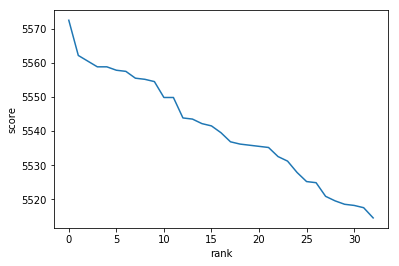

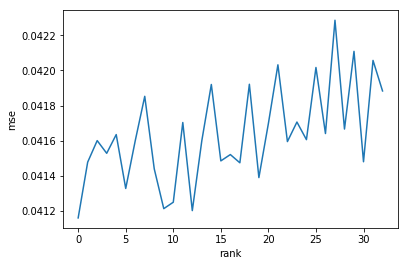

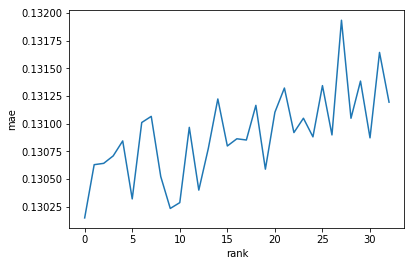

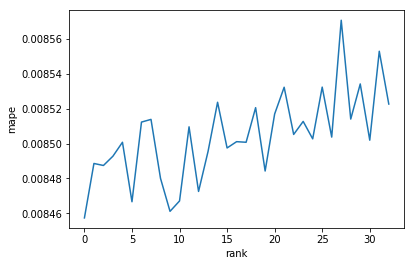

In [18]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

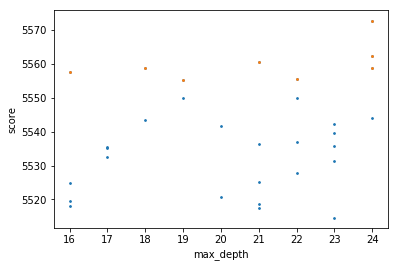

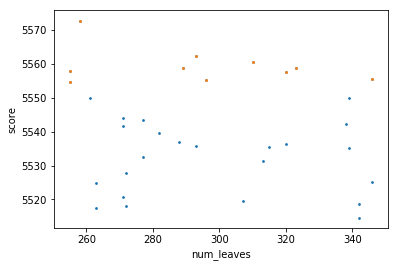

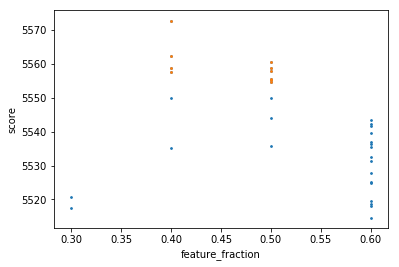

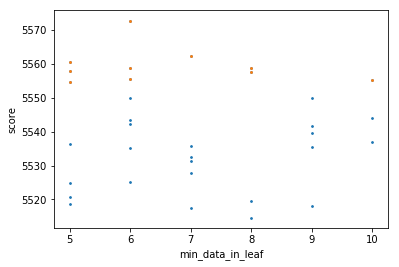

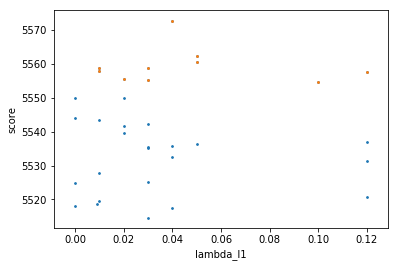

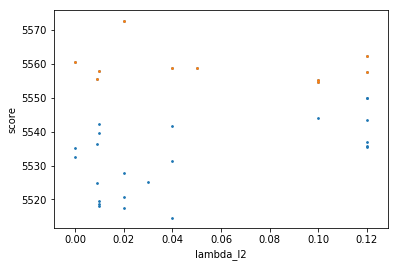

In [19]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=3)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

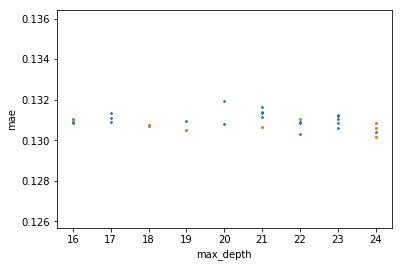

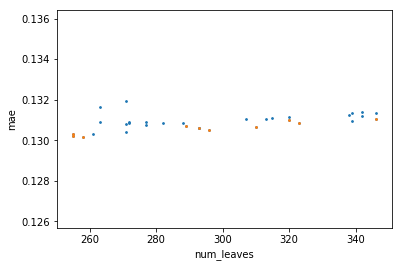

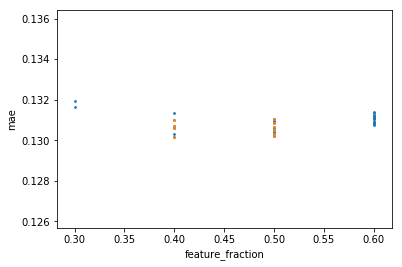

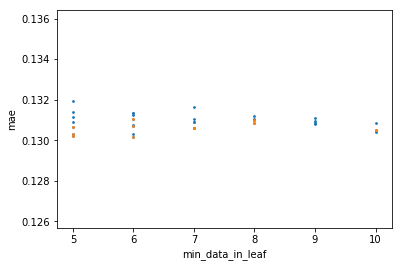

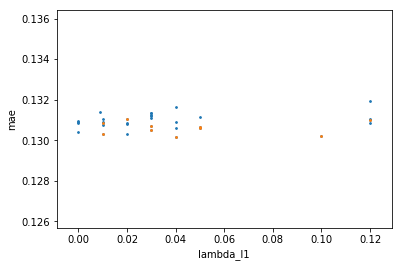

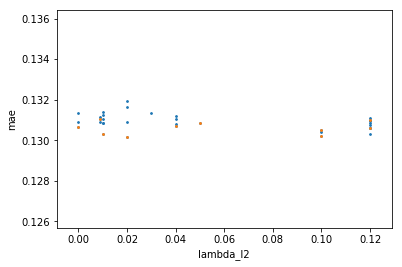

In [20]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=3)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

In [21]:
df_gsearch_results.columns

Index(['max_depth', 'num_leaves', 'feature_fraction', 'min_data_in_leaf',
       'lambda_l1', 'lambda_l2', 'score', 'mse', 'mae', 'mape',
       'best_iteration'],
      dtype='object')

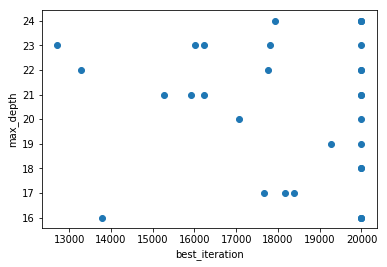

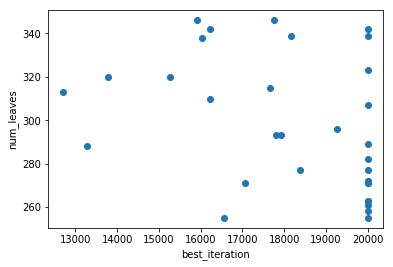

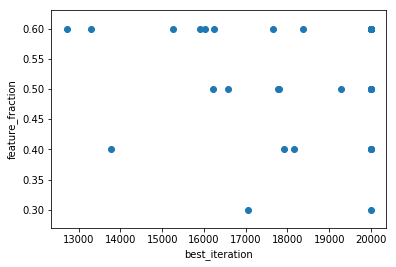

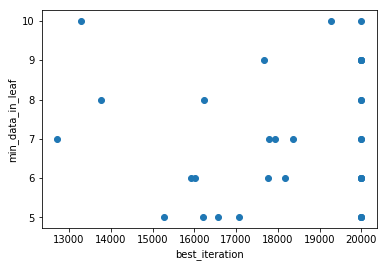

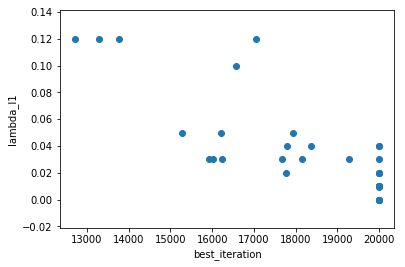

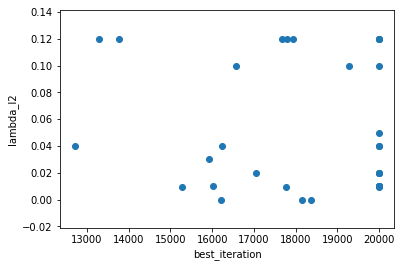

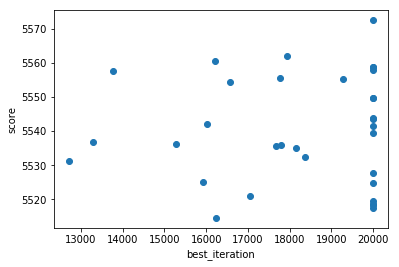

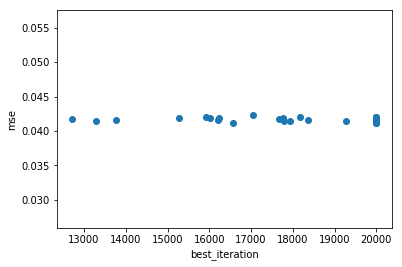

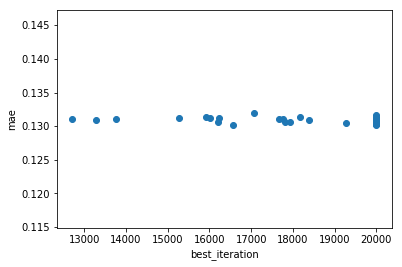

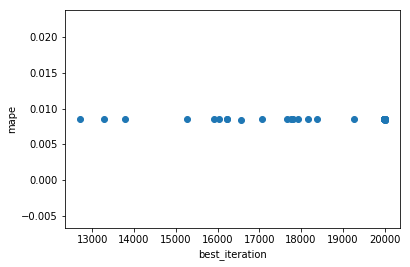

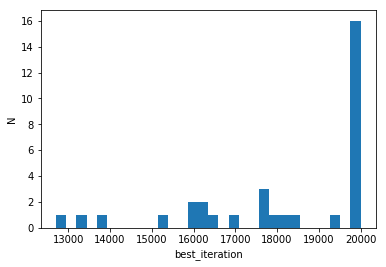

In [22]:
# best iteration
for c in df_gsearch_results.columns:
    if c != 'best_iteration':
        plt.scatter(df_gsearch_results['best_iteration'], df_gsearch_results[c])
        plt.ylabel(c)
    else:
        plt.hist(df_gsearch_results['best_iteration'], bins=30)
        plt.ylabel('N')        
    plt.xlabel('best_iteration')
    plt.show()

### Feature importance
plot for the last model (not the best model)

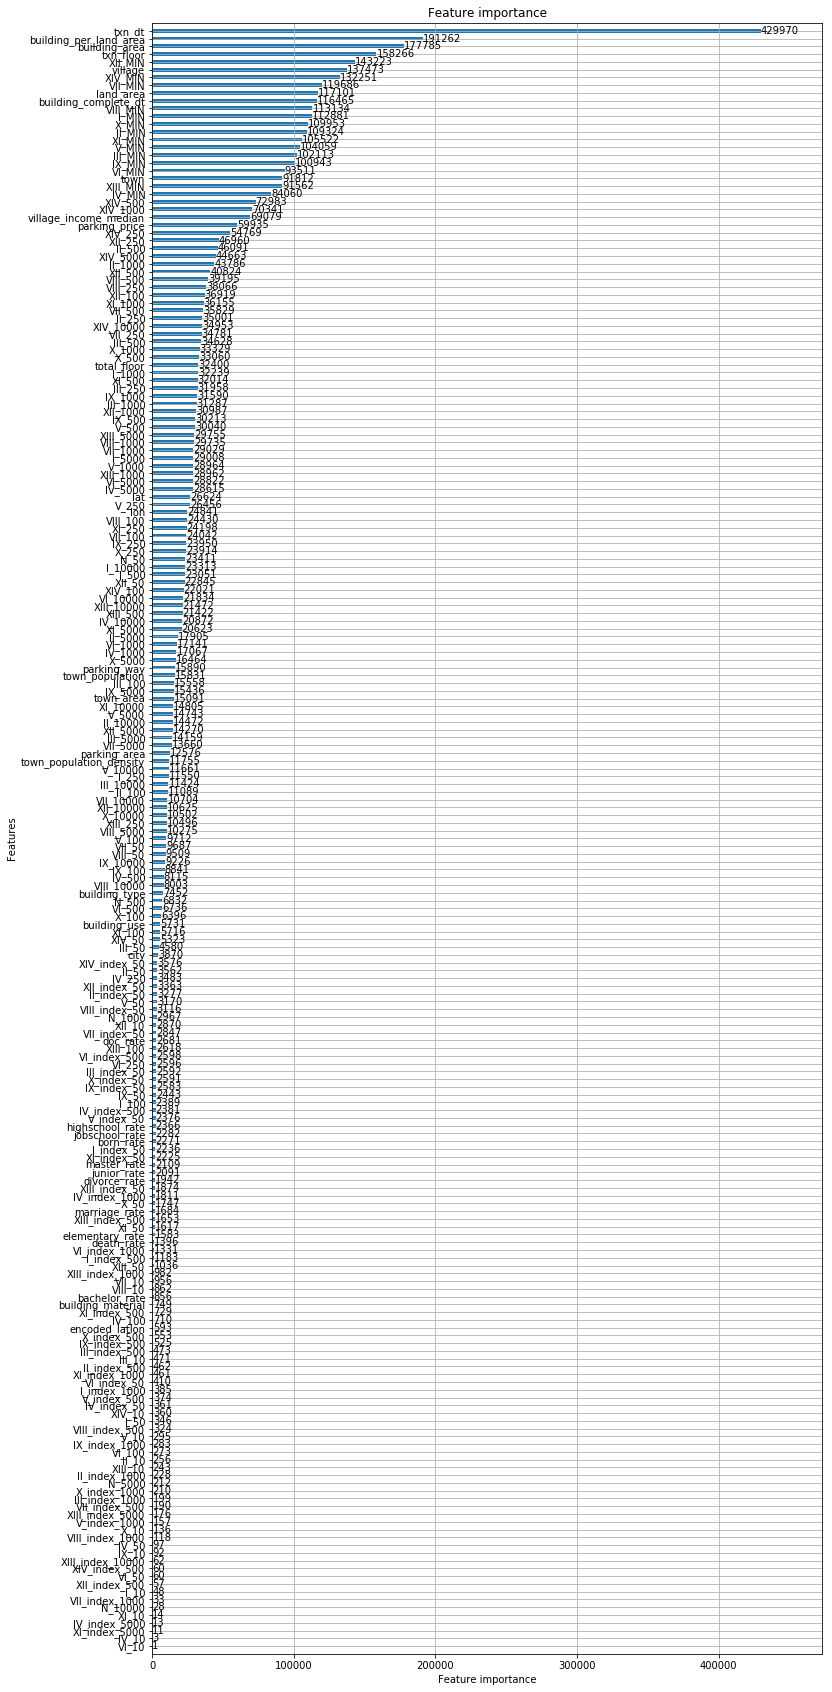

In [24]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

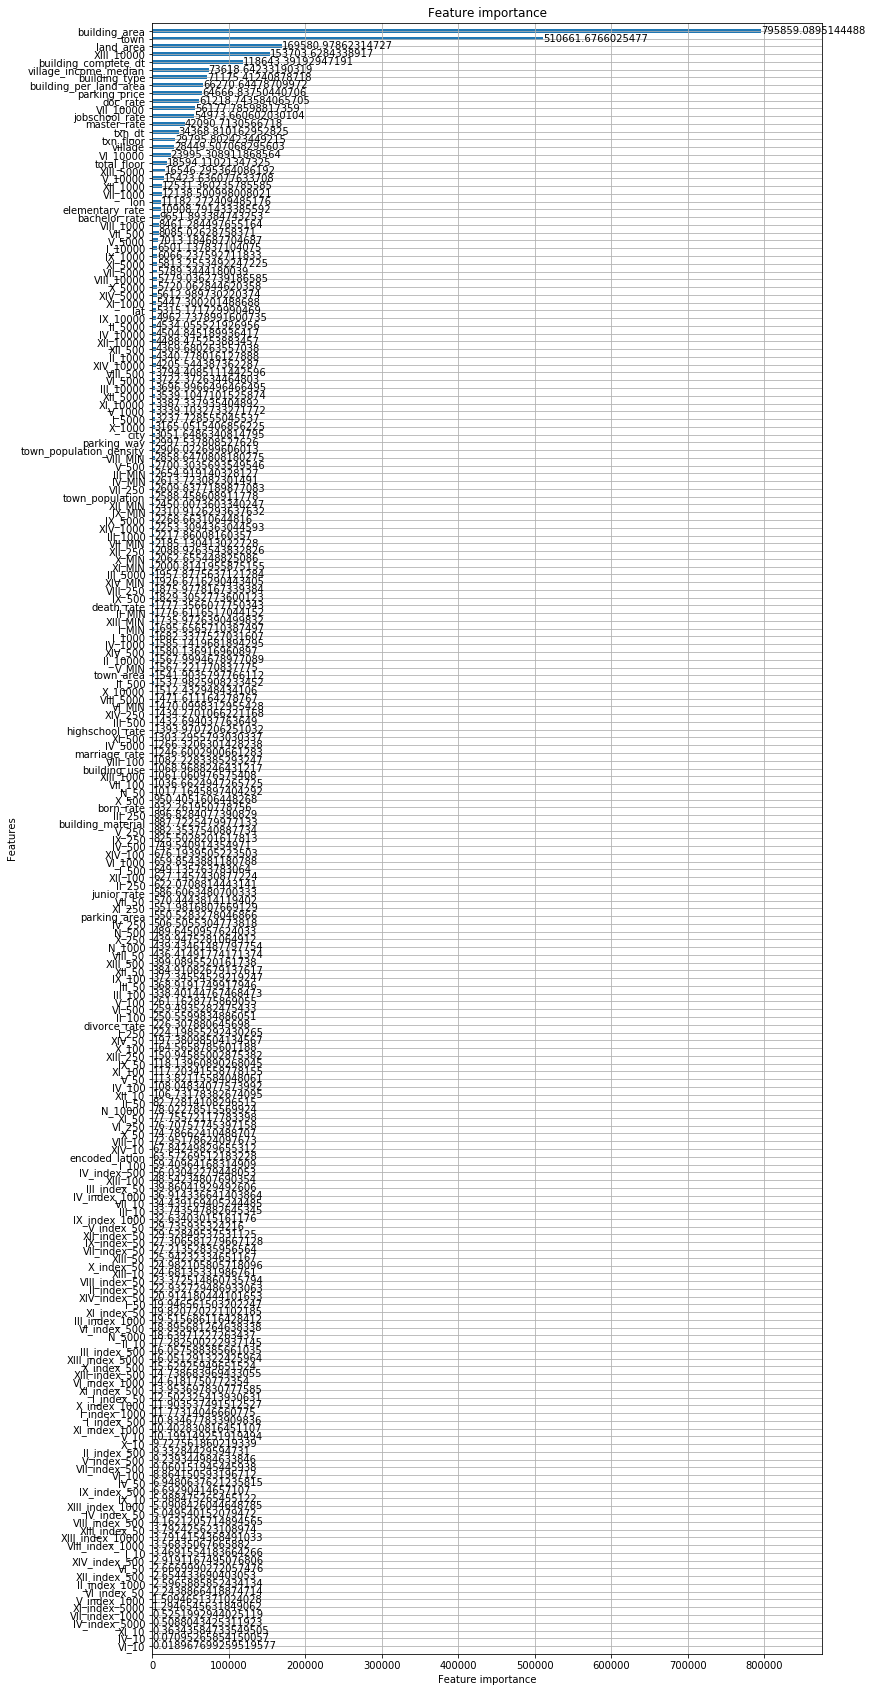

In [25]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()

### Result

(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 258), ('feature_fraction', 0.4), ('min_data_in_leaf', 6), ('lambda_l1', 0.04), ('lambda_l2', 0.02)) 5572.531853533797 0.041159358660136064 0.13014855873453376 0.008457367760595516 [5594.866653335183, 5556.866009941613, 5565.862897324597] [0.039694561131963194, 0.04182964505080578, 0.04195386979763921] [0.1286430962426176, 0.1309269326855727, 0.130875647275411] [0.008355430743138945, 0.008496364070326104, 0.0085203084683215]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 293), ('feature_fraction', 0.4), ('min_data_in_leaf', 7), ('lambda_l1', 0.05), ('lambda_l2', 0.12)) 5562.198038953166 0.04147718627295749 0.13062919686416433 0.008488617303507877 [5586.866032025826, 5539.865561246075, 5559.862523587596] [0.04010172993072562, 0.04214094322531427, 0.04218888566283257] [0.12920917355557665, 0.13132334235099394, 0.13135507468592242] [0.008391548843767522, 0.008523731617163396, 0.008550571449592719]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 21), ('num_leaves', 310), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.05), ('lambda_l2', 0.0)) 5560.531410176075 0.04159998384859362 0.1306411379907101 0.008487470207441436 [5560.865369156181, 5560.866003621008, 5559.862857751038] [0.0406321081536743, 0.04197337779286426, 0.04219446559924229] [0.12987988769764755, 0.13107260521430578, 0.13097092106017694] [0.008433439284782438, 0.008504418959124576, 0.008524552378417295]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 18), ('num_leaves', 289), ('feature_fraction', 0.4), ('min_data_in_leaf', 6), ('lambda_l1', 0.03), ('lambda_l2', 0.04)) 5558.864699147496 0.041527647254451815 0.13070851022948216 0.008492820730959867 [5576.86616712497, 5548.8655894180265, 5550.86234089949] [0.04009211758626721, 0.04221768920572822, 0.04227313497136002] [0.1292163414496937, 0.13135324096155543, 0.13155594827719733] [0.00839069291045058, 0.008523636744343435, 0.008564132538085583]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 323), ('feature_fraction', 0.5), ('min_data_in_leaf', 8), ('lambda_l1', 0.01), ('lambda_l2', 0.05)) 5558.864474202128 0.041634349493959444 0.13084375018357233 0.008500798445619134 [5570.865225577157, 5564.865817149226, 5540.86237988] [0.040532226833251264, 0.041986065833465695, 0.04238475581516138] [0.12999719294669349, 0.13112527532568455, 0.1314087822783389] [0.008441573331633182, 0.008508761269339847, 0.00855206073588437]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.01)) 5557.865010700235 0.041327247543934485 0.13032017336658083 0.008466651106727138 [5556.865560177531, 5565.866591043929, 5550.8628808792455] [0.040421562683999296, 0.04158662052711738, 0.04197355942068678] [0.129702818522896, 0.13042683692431528, 0.13083086465253121] [0.008422042146219352, 0.008463495091002315, 0.008514416082959745]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 320), ('feature_fraction', 0.4), ('min_data_in_leaf', 8), ('lambda_l1', 0.12), ('lambda_l2', 0.12)) 5557.531010198411 0.041599217183478705 0.13100985955981034 0.008512381535824369 [5588.865936955, 5542.865280349232, 5540.861813291005] [0.040087939835339426, 0.042297001609610994, 0.0424127101054857] [0.12935664947159134, 0.13175614918773249, 0.13191678002010726] [0.008401426838920298, 0.008548902983953555, 0.008586814784599252]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 22), ('num_leaves', 346), ('feature_fraction', 0.5), ('min_data_in_leaf', 6), ('lambda_l1', 0.02), ('lambda_l2', 0.009)) 5555.5309981697455 0.0418524413582217 0.13106538254900146 0.00851392629916821 [5576.865256900285, 5526.865433358323, 5562.862304250627] [0.04068351008526952, 0.042339422480278714, 0.04253439150911686] [0.1300339004584577, 0.13162855888537525, 0.13153368830317144] [0.008442226824420236, 0.008539011042243876, 0.008560541030840519]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 19), ('num_leaves', 296), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.03), ('lambda_l2', 0.1)) 5555.198049981441 0.04143871524007952 0.13052161424379868 0.008480083442524367 [5562.865469414061, 5548.8661600208625, 5553.862520509399] [0.04036924322321393, 0.04180576591411819, 0.04214113658290643] [0.12973364369949708, 0.13075536094479084, 0.13107583808710807] [0.008425064451494105, 0.008484063150540259, 0.008531122725538739]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.1)) 5554.531765266432 0.04121219113262665 0.13023403893373345 0.008461141606859754 [5564.865616026388, 5534.866707131491, 5563.862972641417] [0.04029757138443781, 0.041422777296677454, 0.04191622471676468] [0.1295983310428357, 0.1303642533540129, 0.13073953240435174] [0.008414741034664698, 0.008458992950308303, 0.00850969083560626]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 22), ('num_leaves', 261), ('feature_fraction', 0.4), ('min_data_in_leaf', 6), ('lambda_l1', 0.02), ('lambda_l2', 0.12)) 5549.86506403045 0.04124884164328813 0.13028653064508758 0.008467103282458444 [5570.866522454107, 5526.865812581542, 5551.862857055703] [0.039828687710086956, 0.041930349837489604, 0.04198748738228784] [0.12878115106372345, 0.13107722965542315, 0.13100121121611616] [0.008364692443332475, 0.00850741249455027, 0.008529204909492591]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 19), ('num_leaves', 339), ('feature_fraction', 0.5), ('min_data_in_leaf', 9), ('lambda_l1', 0.0), ('lambda_l2', 0.12)) 5549.8643058104235 0.04170312374677334 0.13096604024118194 0.008509658736742233 [5558.864959887164, 5540.865784823768, 5549.862172720336] [0.040727730071863845, 0.04204850778316501, 0.04233313338529116] [0.1302374059805649, 0.13118270187077055, 0.1314780128722103] [0.008457731069124832, 0.008512392656491436, 0.00855885248461043]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 271), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.1)) 5543.8647936489715 0.04120098079044097 0.13039966100149317 0.008472567703617075 [5544.86567833006, 5562.866329784951, 5523.862372831903] [0.04014057197327652, 0.04148277213686934, 0.04197959826117704] [0.12950827678737944, 0.1305845644453983, 0.1311061417717018] [0.008410307826899999, 0.00847391441652342, 0.008533480867427804]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 18), ('num_leaves', 277), ('feature_fraction', 0.6), ('min_data_in_leaf', 6), ('lambda_l1', 0.01), ('lambda_l2', 0.12)) 5543.531090409567 0.041599413831264954 0.1307756768994943 0.00849556754029876 [5544.8652136033315, 5546.865948884226, 5538.86210874114] [0.04053537007577153, 0.04197940745513987, 0.04228346396288348] [0.1299755566419885, 0.13101938192390375, 0.1313320921325906] [0.008439706823227288, 0.008499744968325772, 0.00854725082934322]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 23), ('num_leaves', 338), ('feature_fraction', 0.6), ('min_data_in_leaf', 6), ('lambda_l1', 0.03), ('lambda_l2', 0.01)) 5542.197377146869 0.04191984029667043 0.13122231540032545 0.00852375519929392 [5532.864291339998, 5542.865590189262, 5550.86224991135] [0.04110842303115479, 0.042248673126060364, 0.04240242473279616] [0.13089883879880565, 0.1314474317449061, 0.1313206756572646] [0.008497857497501109, 0.008526790282685291, 0.00854661781769536]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 20), ('num_leaves', 271), ('feature_fraction', 0.6), ('min_data_in_leaf', 9), ('lambda_l1', 0.02), ('lambda_l2', 0.04)) 5541.530977640515 0.04148434837434847 0.1307979361181689 0.008497524496490301 [5544.864708548061, 5528.8662967035925, 5550.861927669891] [0.04064558361764394, 0.041660597687914906, 0.042146863817486564] [0.13037284055506212, 0.13067005458667014, 0.13135091321277437] [0.00846593927203496, 0.008478432535163881, 0.008548201682272062]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 23), ('num_leaves', 282), ('feature_fraction', 0.6), ('min_data_in_leaf', 9), ('lambda_l1', 0.02), ('lambda_l2', 0.01)) 5539.530951254293 0.04152047345036034 0.13086295160358652 0.008501141923522722 [5544.864781471272, 5528.86601219751, 5544.862060094094] [0.040491161850782616, 0.04185014734834134, 0.04222011115195708] [0.13028579184036038, 0.13103599554357093, 0.13126706742682823] [0.008459352290996596, 0.008501115989763774, 0.008542957489807792]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 22), ('num_leaves', 288), ('feature_fraction', 0.6), ('min_data_in_leaf', 10), ('lambda_l1', 0.12), ('lambda_l2', 0.12)) 5536.864245778069 0.04147351212935493 0.1308519164714551 0.008500796133626873 [5532.864709588966, 5532.865933434583, 5544.862094310654] [0.040454638324733574, 0.04178614737025087, 0.042179750693080345] [0.13029576920991376, 0.13097749688044807, 0.13128248332400347] [0.008460101694272968, 0.008498840417789037, 0.008543446288818618]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 21), ('num_leaves', 320), ('feature_fraction', 0.6), ('min_data_in_leaf', 5), ('lambda_l1', 0.05), ('lambda_l2', 0.009)) 5536.197440993698 0.041921160957367 0.13116471715748076 0.008520664776169272 [5518.864713432009, 5556.865562443462, 5532.862047105624] [0.04097659348010175, 0.042318135727271076, 0.04246875366472816] [0.13049994952548583, 0.13142628769610087, 0.13156791425085554] [0.008472110376204904, 0.008526285980468068, 0.008563597971834846]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 23), ('num_leaves', 293), ('feature_fraction', 0.5), ('min_data_in_leaf', 7), ('lambda_l1', 0.04), ('lambda_l2', 0.12)) 5535.8647855439085 0.041389197729539716 0.13058866639689076 0.00848429798440066 [5540.865601321782, 5526.866053075169, 5539.8627022347755] [0.040298629080340785, 0.0417429543516391, 0.04212600975663926] [0.1296995127581146, 0.13098975518982003, 0.13107673124273767] [0.008421578562013402, 0.008499821458800735, 0.008531493932387842]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 17), ('num_leaves', 315), ('feature_fraction', 0.6), ('min_data_in_leaf', 9), ('lambda_l1', 0.03), ('lambda_l2', 0.12)) 5535.530761740421 0.041697807346322426 0.131102607147791 0.00851702670064175 [5524.864791507051, 5558.865815692105, 5522.86167802211] [0.04057707379254995, 0.04207301884743863, 0.042443329398978706] [0.13036999253066878, 0.1312284007039274, 0.13170942820877682] [0.008464497182475873, 0.00851360153853128, 0.008572981380918094]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 17), ('num_leaves', 339), ('feature_fraction', 0.4), ('min_data_in_leaf', 6), ('lambda_l1', 0.03), ('lambda_l2', 0.0)) 5535.197437299244 0.04203192824052149 0.13132109246178883 0.008532385228621223 [5543.865313421242, 5524.8649907266, 5536.862007749889] [0.04076707890389871, 0.04266047404619281, 0.04266823177147293] [0.13007112277911348, 0.1319579669456711, 0.1319341876605819] [0.008445762916997227, 0.008562233752167293, 0.008589159016699146]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 17), ('num_leaves', 277), ('feature_fraction', 0.6), ('min_data_in_leaf', 7), ('lambda_l1', 0.04), ('lambda_l2', 0.0)) 5532.530965231986 0.04159441766216585 0.13091904570674992 0.008505291595267327 [5544.86496477203, 5520.865739990163, 5531.862190933763] [0.04051869017922677, 0.04200481981329757, 0.04225974299397323] [0.1302244520404349, 0.13119226150974725, 0.13134042357006756] [0.008455639037834911, 0.008512829802610542, 0.008547405945356527]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 23), ('num_leaves', 313), ('feature_fraction', 0.6), ('min_data_in_leaf', 7), ('lambda_l1', 0.12), ('lambda_l2', 0.04)) 5531.197502533665 0.041705753560816426 0.13104850148220412 0.008512766038520808 [5529.8646140437795, 5518.86587599056, 5544.862017566655] [0.04065154347854418, 0.04202002918439352, 0.042445688019511554] [0.13050940001167763, 0.13111806206931595, 0.13151804236561873] [0.008472816352768805, 0.008507121939108993, 0.008558359823684625]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 22), ('num_leaves', 272), ('feature_fraction', 0.6), ('min_data_in_leaf', 7), ('lambda_l1', 0.01), ('lambda_l2', 0.02)) 5527.864338826964 0.04160548539755602 0.13088030764855677 0.008502758059953154 [5536.865015809245, 5516.865936285311, 5529.862064386335] [0.040494279512803544, 0.04203332609936558, 0.042288850580498936] [0.13013071612448535, 0.13108748573346726, 0.13142272108771763] [0.008450017884198031, 0.008504405243235562, 0.00855385105242587]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 21), ('num_leaves', 346), ('feature_fraction', 0.6), ('min_data_in_leaf', 6), ('lambda_l1', 0.03), ('lambda_l2', 0.03)) 5525.1971691455265 0.042016738678403304 0.1313428342773224 0.008532459472410922 [5516.864455751465, 5547.865380030791, 5510.861671654324] [0.041020050597090345, 0.04240709956007101, 0.042623065878048566] [0.13073012207535484, 0.13155479626625852, 0.13174358449035384] [0.00848711829013579, 0.008534557698660314, 0.008575702428436662]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 263), ('feature_fraction', 0.6), ('min_data_in_leaf', 5), ('lambda_l1', 0.0), ('lambda_l2', 0.009)) 5524.864312197184 0.04164024083796844 0.13089778962208418 0.008503769867816926 [5530.864896285382, 5526.865891451418, 5516.862148854749] [0.04056243578764132, 0.042056188376115744, 0.04230209835014825] [0.13024071491225694, 0.13109766333625614, 0.13135499061773948] [0.008456885111351958, 0.008505475705542007, 0.008548948786556812]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 20), ('num_leaves', 271), ('feature_fraction', 0.3), ('min_data_in_leaf', 5), ('lambda_l1', 0.12), ('lambda_l2', 0.02)) 5520.8635371076225 0.0422860155189618 0.13193307169782073 0.008570846507296339 [5510.864560067792, 5528.865112551061, 5522.8609387040115] [0.041022604282254044, 0.04257484067024632, 0.04326060160438503] [0.13079492758876132, 0.1321768756727399, 0.13282741183196092] [0.008493864701087196, 0.008575818348476722, 0.0086428564723251]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 307), ('feature_fraction', 0.6), ('min_data_in_leaf', 8), ('lambda_l1', 0.01), ('lambda_l2', 0.01)) 5519.530771419101 0.0416659281995164 0.1310482093483006 0.008514116321206985 [5518.864649744822, 5526.865770074209, 5512.861894438274] [0.040738955651276984, 0.04194228604445318, 0.04231654290281906] [0.1305008207862467, 0.1310925742090889, 0.1315512330495662] [0.008473517621221205, 0.008505744533219003, 0.008563086809180751]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 21), ('num_leaves', 342), ('feature_fraction', 0.6), ('min_data_in_leaf', 5), ('lambda_l1', 0.009), ('lambda_l2', 0.01)) 5518.530559553851 0.04210863868714795 0.13138383466940776 0.008534274942705448 [5502.864611548742, 5532.865099191741, 5519.86196792107] [0.041077352142105054, 0.04268437118208139, 0.042564192737257416] [0.13063817499278427, 0.1318092607425651, 0.1317040682728739] [0.008480232152648929, 0.008550571593500738, 0.008572021081966679]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 272), ('feature_fraction', 0.6), ('min_data_in_leaf', 9), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5518.197626091386 0.04147946423935436 0.13087142429172038 0.008501991116305613 [5533.865145783418, 5516.865804181106, 5503.861928309634] [0.04029700664101766, 0.041915796820735374, 0.04222558925631007] [0.13003353657928296, 0.13117692449221324, 0.13140381180366498] [0.008444329696864723, 0.008510396832937112, 0.008551246819115005]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 21), ('num_leaves', 263), ('feature_fraction', 0.3), ('min_data_in_leaf', 7), ('lambda_l1', 0.04), ('lambda_l2', 0.02)) 5517.530459947083 0.04205698176693132 0.13164247734045229 0.008553045847822181 [5516.865103489447, 5530.865146024929, 5504.86113032687] [0.04062049268993397, 0.04248249281946194, 0.04306795979139805] [0.1302938565630341, 0.13209478187437504, 0.13253879358394774] [0.008462773517876769, 0.008571554049618816, 0.008624809975970956]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 23), ('num_leaves', 342), ('feature_fraction', 0.6), ('min_data_in_leaf', 8), ('lambda_l1', 0.03), ('lambda_l2', 0.04)) 5514.530647221264 0.041883041650767915 0.13119345239328364 0.008522732740129173 [5504.864554197132, 5525.865656005916, 5512.861731460743] [0.04092812710166911, 0.042217526527888315, 0.0425034713227463] [0.13058917289031155, 0.1313294575993303, 0.13166172669020917] [0.008477863546353269, 0.008520947128047867, 0.008569387545986382]